# Metrics Visualization and Analysis of Asteroids AI Agents
This section presents an analysis of evaluation data collected from Asteroids agents trained using multiple reinforcement learning algorithms and reward function personas. To facilitate objective comparison, several key metrics were automatically recorded during each evaluation episode. The primary metrics considered are:

- Score: The total points accumulated before each episode ended.
- Episode Steps: The number of game steps survived in each evaluation episode.
- Bullets Fired & Accuracy: Measures of agent interaction frequency and precision in the game environment.
- Score Rate: The speed at which points are gained, highlighting agents that achieve rapid improvement.

These metrics were selected as they provide clear indicators of agent performance and adaptability to gameplay demands. The results are visualized using box plots, which illustrate the distribution of each metric for every (persona, model) combination.

1. First we must do all relavant imports.
2. Then import the evaluation data.

In [63]:
import pandas as pd
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def extract_model_persona_from_fname(fname):
    # Example: asteroids_a2c_asteroids_hunter_novice_eval.json
    parts = fname.lower().split('_')
    model, persona = None, None
    for i, p in enumerate(parts):
        if p in ('a2c', 'ppo'):
            model = p
            if i + 2 < len(parts):
                persona = parts[i + 2]
            break
    return model, persona

# Data Import
all_rows = []
for fname in glob.glob('../models/*.json'):
    model, persona = extract_model_persona_from_fname(fname)
    with open(fname) as f:
        data = json.load(f)
        if isinstance(data, list):
            for row in data:
                row['file'] = fname
                row['model'] = model
                row['persona'] = persona
                all_rows.append(row)
        elif isinstance(data, dict):
            num_eps = len(data.get('scores', []))
            for i in range(num_eps):
                row = {'file': fname, 'model': model, 'persona': persona}
                for key in data:
                    if isinstance(data[key], list):
                        row[key] = data[key][i]
                    else:
                        row[key] = data[key]
                all_rows.append(row)

all_df = pd.DataFrame(all_rows)

# Confirm column names exist (to avoid KeyError)
# print("\nColumns in DataFrame:", all_df.columns.tolist())

3. Next we prepare the data to used by formating it into a useable form.
4. Then set up the the colour scheme and pallet.

In [64]:
def extract_scalar(val):
    """
    If val is a list or numpy array, returns the first element if available,
    else returns np.nan. Otherwise, returns val unchanged.
    """
    if isinstance(val, (list, np.ndarray)):
        return val[0] if len(val) else np.nan
    return val

# Example usage for DataFrame columns you want to flatten:
columns_to_flatten = ['episode_steps', 'scores', 'episode_rewards']

for col in columns_to_flatten:
    if col in all_df.columns:
        all_df[col] = all_df[col].apply(extract_scalar).astype(float)
    else:
        print(f"Column '{col}' not found in DataFrame.")

# You can print the head to confirm:
print(all_df.head())


   episodes  episode_steps   scores levels bullets_fired asteroids_destroyed  \
0         1         1219.0   4480.0    [2]          [97]                [60]   
1         1          880.0   3030.0    [2]          [79]                [43]   
2         1         1307.0   6450.0    [3]         [110]                [88]   
3         1         3851.0  12930.0    [5]         [316]               [175]   
4         1         1202.0   4580.0    [2]         [109]                [61]   

       episode_accuracy episode_score_per_min episode_reward_per_min  \
0  [0.6185567010309279]  [220.50861361771945]                 [60.0]   
1  [0.5443037974683544]   [206.5909090909091]                 [60.0]   
2                 [0.8]  [296.09793420045906]    [59.99999999999999]   
3  [0.5537974683544303]   [201.4541677486367]                 [60.0]   
4  [0.5596330275229358]  [228.61896838602328]    [59.99999999999999]   

  episode_score_reward_ratio  ...        mean_distances    deaths_by  \
0        [3.67

In [65]:
# ----------------------------------------
# Color Palettes and Group Configuration
# ----------------------------------------

# Define persona-specific color palette
persona_palette = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00',
    '#a65628', '#f781bf', '#999999', '#dede00', '#000000'
]

# Map persona names to colors
persona_list = sorted(all_df['persona'].unique())
persona_color_map = {
    persona: persona_palette[i % len(persona_palette)]
    for i, persona in enumerate(persona_list)
}

# Define model-level colors and persona markers
model_colors = {'a2c': '#e6550d', 'ppo': '#3182bd'}
persona_markers = {
    'hunter': 'o',
    'survivor': 's',
    'baseline': '^',
    'speedrunner': 'D',
    'simple': 'v'
}

# ----------------------------------------
# Data Preparation for Grouping
# ----------------------------------------

df_plot = all_df.copy()

# Flatten numeric lists if necessary
for col in ['scores', 'episode_steps', 'episode_accuracy', 
            'episode_score_per_min', 'bullets_fired']:
    if col in df_plot.columns:
        df_plot[col] = df_plot[col].apply(extract_scalar).astype(float)

# Create combined group label (persona-model)
df_plot['group'] = df_plot['persona'] + '-' + df_plot['model']

# ----------------------------------------
# Generate Group-Specific Palettes
# ----------------------------------------

groups = sorted(df_plot['group'].unique())
ppo_groups = [g for g in groups if 'ppo' in g]
a2c_groups = [g for g in groups if 'a2c' in g]

palette = {}

# Themed palettes per algorithm type
ppo_colors = sns.color_palette("Blues", len(ppo_groups))
a2c_colors = sns.color_palette("Oranges", len(a2c_groups))

for g, c in zip(ppo_groups, ppo_colors):
    palette[g] = c
for g, c in zip(a2c_groups, a2c_colors):
    palette[g] = c

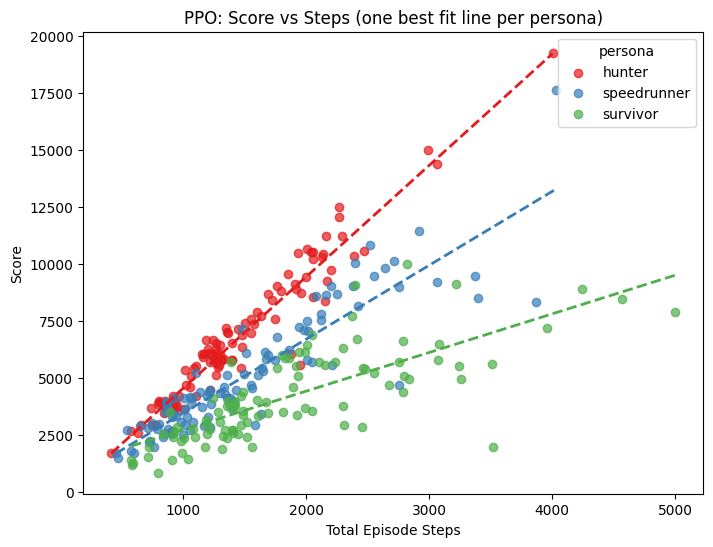

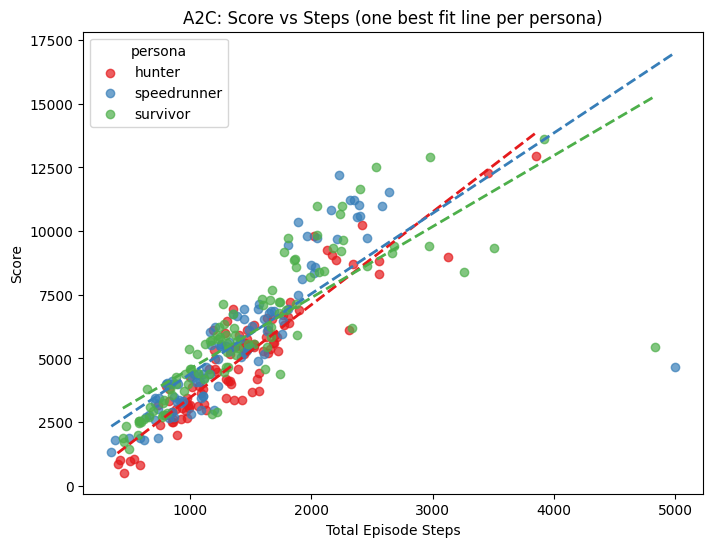

In [66]:
# -- 1. PPO only: color by persona, best fit per persona --
plt.figure(figsize=(8,6))
df = all_df[all_df['model'] == 'ppo']
for persona in df['persona'].unique():
    mask = (df['persona'] == persona)
    x = df.loc[mask, 'episode_steps']
    y = df.loc[mask, 'scores']
    plt.scatter(
        x, y,
        color=persona_color_map[persona],
        marker='o',
        label=persona,
        alpha=0.7
    )
    if len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        plt.plot(
            np.sort(x),
            m * np.sort(x) + b,
            color=persona_color_map[persona],
            linestyle='--',
            linewidth=2
        )
plt.legend(title='persona')
plt.title('PPO: Score vs Steps (one best fit line per persona)')
plt.xlabel('Total Episode Steps')
plt.ylabel('Score')
plt.show()

# -- 2. A2C only: color by persona, best fit per persona --
plt.figure(figsize=(8,6))
df = all_df[all_df['model'] == 'a2c']
for persona in df['persona'].unique():
    mask = (df['persona'] == persona)
    x = df.loc[mask, 'episode_steps']
    y = df.loc[mask, 'scores']
    plt.scatter(
        x, y,
        color=persona_color_map[persona],
        marker='o',
        label=persona,
        alpha=0.7
    )
    if len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        plt.plot(
            np.sort(x),
            m * np.sort(x) + b,
            color=persona_color_map[persona],
            linestyle='--',
            linewidth=2
        )
plt.legend(title='persona')
plt.title('A2C: Score vs Steps (one best fit line per persona)')
plt.xlabel('Total Episode Steps')
plt.ylabel('Score')
plt.show()


The scatterplots illustrate the relationship between total episode steps and scores for each persona and learning algorithm. 

Positive Correlation: Across both A2C and PPO agents, there is a clear positive correlation between episode length (steps) and total score. Agents that survive longer tend to accumulate higher scores, as represented by the upward trend of all best-fit lines.

The A2C agents display minimal differentiation among the hunter, speedrunner, and survivor personas. Their trendlines are closely grouped, indicating that reward shaping has only a limited effect on how A2C agents translate episode length into game score. Most personas show similar levels of performance and behavioral consistency. This suggests that A2C may be less sensitive to reward structure variations, producing agents whose strategies converge regardless of the assigned persona.

Closer examination of the PPO scatterplot highlights several interesting differences in how reward shaping influenced agent behavior:

Speedrunner Underperformance: 
Although the speedrunner persona was explicitly designed to encourage aggressive, high-scoring strategies, this group consistently underperformed compared to the hunter persona. Despite having a reward structure meant to incentivize assertive play and quick point gains, PPO speedrunner agents failed to reach the same score-per-step efficiency as hunters. Their best-fit line is noticeably shallower, and their score distribution is lower and more dispersed. This may suggest that the PPO algorithm was less able to reliably exploit the speedrunner’s aggressive strategy, or that the reward signals led to more chaotic or risky behaviors that did not consistently translate into higher scores.

Hunter Outperformance: 
In contrast, the hunter persona achieved the steepest trendline in the PPO group, consistently translating moderate episode lengths into high scores. The hunter reward, despite being less aggressive than the speedrunner’s resulted in agents that efficiently combined survivability and score maximization.

Survivor Consistency: 
The survivor persona, on the other hand, exhibited the longest episode survival times among all groups, as reflected by its horizontal spread across the steps axis. Although scores for survivor agents tended to be lower, the consistency and duration of survival suggest a strong alignment between the persona’s reward shaping and actual agent behavior.

These findings indicate that, in this implementation, aggressive reward shaping does not always yield higher game scores—especially under PPO—even when intended to do so. Different personas interact distinctly with the RL algorithm, and survivor agents illustrate a trade-off between risk-taking and longevity. The overall results highlight the need for careful alignment between reward structure and RL algorithm choice to achieve desired agent behaviors.

Algorithm Impact: 
These findings imply that PPO acts as a more effective trainer for differentiating agent policy based on reward signals, whereas A2C tends to smooth out behavioral differences among personas. The clearer division of persona outcomes under PPO highlights its capacity for fine-tuned policy learning and underscores the importance of algorithm selection when designing experiments for agent specialization.

## Persona Comparison Across Models
After separately analyzing the effects of model architecture on agent behavior, the next step is to compare how each persona performs across both PPO and A2C algorithms. The following graphs present direct side-by-side evaluations for each persona, visualizing score versus episode steps with best-fit lines distinguished by model.

By overlaying PPO and A2C data for the survivor, hunter, and speedrunner personas, these plots provide deeper insights into how agent personality interacts with training algorithm. The analysis highlights not only which combinations yield superior scores or survivability, but also the strengths and limitations of each model in supporting specialized gameplay strategies for each persona.

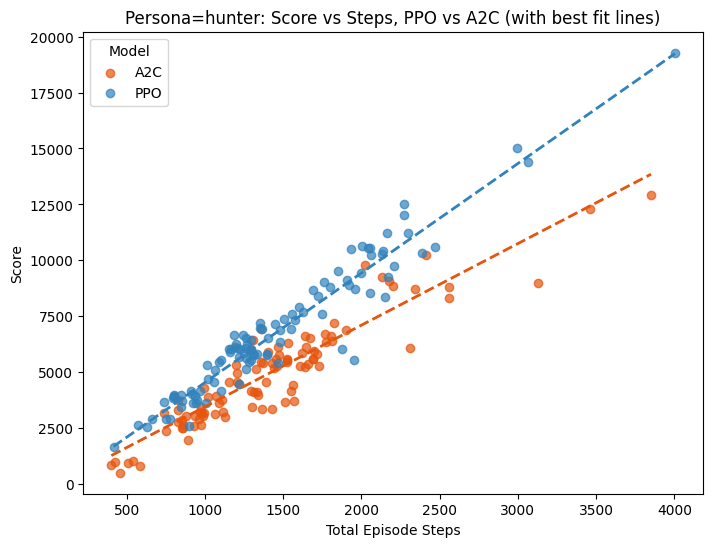

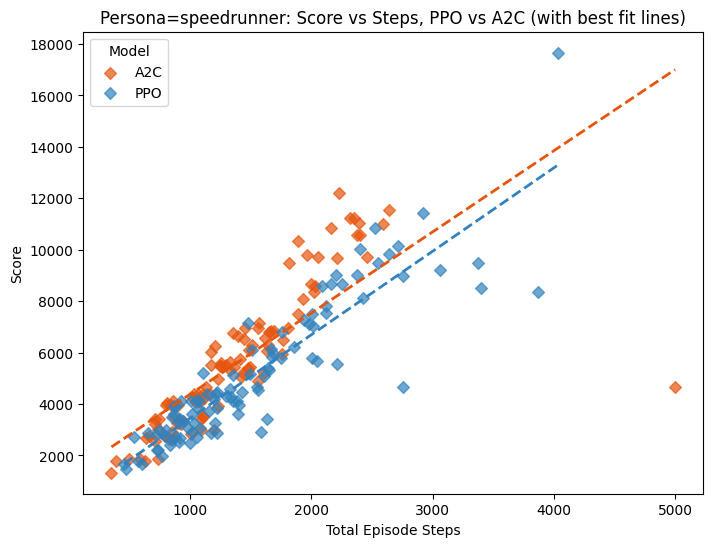

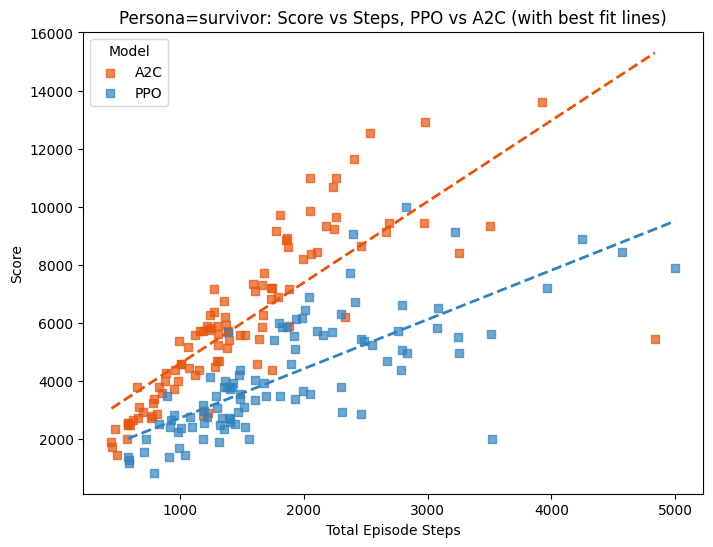

In [67]:
for persona in all_df['persona'].unique():
    plt.figure(figsize=(8,6))
    df = all_df[all_df['persona'] == persona]
    for model in df['model'].unique():
        mask = (df['model'] == model)
        x = df.loc[mask, 'episode_steps']
        y = df.loc[mask, 'scores']
        plt.scatter(
            x, y,
            color=model_colors.get(model, 'gray'),
            marker=persona_markers.get(persona, 'o'),
            label=model.upper(),
            alpha=0.7
        )
        # line of best fit for this model
        if len(x) > 1:
            m, b = np.polyfit(x, y, 1)
            plt.plot(
                np.sort(x),
                m * np.sort(x) + b,
                color=model_colors.get(model, 'gray'),
                linestyle='--',
                linewidth=2
            )
    plt.legend(title='Model')
    plt.title(f'Persona={persona}: Score vs Steps, PPO vs A2C (with best fit lines)')
    plt.xlabel('Total Episode Steps')
    plt.ylabel('Score')
    plt.show()


### Hunter Persona:
The hunter persona demonstrates a trend of PPO outperforming A2C at nearly all episode lengths. The PPO fit line rises sharply, indicating exceptional scoring efficiency even in moderately long episodes. This finding aligns with previous analyses showing PPO-trained hunters combine high-risk behavior with high reward, maximizing scores per step. In contrast, A2C-trained hunter agents exhibit lower absolute scores and a gentler slope, indicating less aggressive scoring and possibly more conservative strategies. This highlights the strong synergy between the hunter reward structure and the PPO training method.

### Speedrunner Persona:
For speedrunner, performance is closely matched between PPO and A2C. The fit lines for both models have similar slopes, and most episode lengths yield comparable scores regardless of the RL algorithm used. There is a mild advantage for A2C at select episode durations, suggesting the aggressive reward designed for speedrunners does not translate to significantly different behaviors or outcomes for PPO and A2C. This uniformity may be due to limitations in the reward structure, or to both algorithms quickly converging on similar policies.

### Survivor Persona:
The scatterplot for the survivor persona indicates that A2C consistently provides superior score outcomes compared to PPO across nearly all episode lengths. The steeper trendline associated with A2C shows that its agents are more effective at converting survival time into higher scores, closely aligning with the survivor persona's goal of balanced longevity and point collection.

A closer inspection of data clustering reveals nuanced differences in episode length distribution between models. A2C agents most frequently cluster their episode steps in the 500–2000 range, which suggests a degree of stability in how long these agents survive before termination. In contrast, PPO agents exhibit a slight shift towards longer episodes, with clustering around the 1500–2000 steps range. This pattern may suggest a marginal improvement in PPO's consistency with respect to episode duration, possibly reflecting a policy that prioritizes survival more reliably.

However, this consistency in longevity achieved by PPO comes at the expense of game score. Even within similar clusters of episode length, A2C agents almost always outperform PPO agents in total points, underscoring A2C’s greater efficiency in executing the survivor strategy. The survivor-specific reward structure appears more effectively leveraged by A2C’s policy updates, while PPO agents may trade off aggressive scoring for stability and risk-avoidance. Overall, the pattern highlights that reward alignment and episode consistency are sensitive to algorithm design, and optimal survivor behavior is best captured by A2C under the conditions tested.

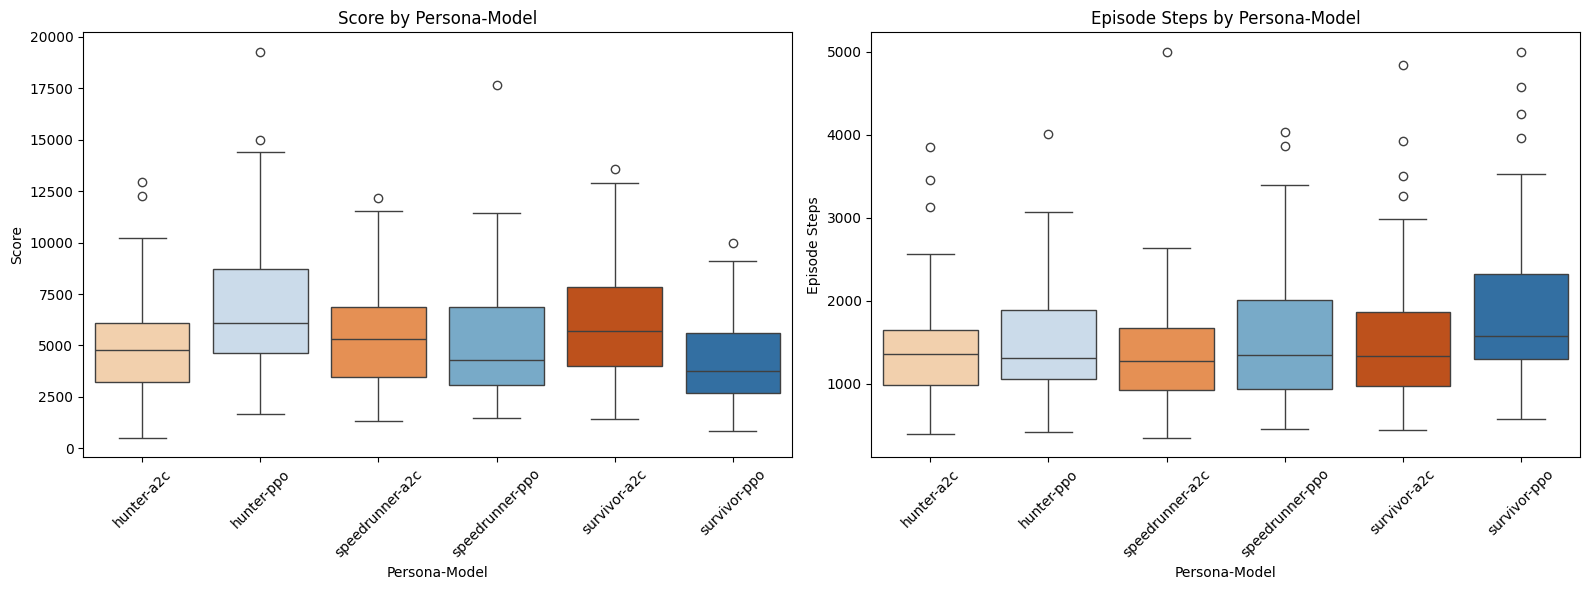

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
metrics = [('score', 'Score'), ('episode_steps_flat', 'Episode Steps')]
df_plot.columns.tolist()
df_plot['score'] = df_plot['scores']
df_plot['episode_steps_flat'] = df_plot['episode_steps'] 

for ax, (col, label) in zip(axes, metrics):
    sns.boxplot(
        data=df_plot,
        x='group',
        y=col,
        order=groups,
        hue='group',
        palette=palette,
        ax=ax,
        showfliers=True
    )
    ax.set_title(label + " by Persona-Model")
    ax.set_xlabel("Persona-Model")
    ax.set_ylabel(label)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()


## Boxplot Analysis: Score and Episode Steps by Persona-Model
### Score Distribution

The highest overall scores are achieved by the "hunter-ppo" group, as shown by their elevated median and the presence of several high-value outliers. "hunter-a2c" and both speedrunner groups produce similar median scores, though the upper range for "speedrunner-ppo" exhibits some high outliers.

"survivor-a2c" shows a relatively high median score and a wide spread, while "survivor-ppo" demonstrates both the lowest median and smallest range among all groups, indicating weaker scoring performance with PPO for this persona.

### Episode Steps Distribution

"survivor-ppo" agents exhibit the highest median episode lengths and a long upper tail, confirming this group's focus on survival over points. "survivor-a2c" also has extended lifetimes, albeit to a slightly lesser extent.

"hunter" and "speedrunner" agents (both A2C and PPO) display similar distributions for episode steps, clustering around shorter episode durations, implying more aggressive and possibly riskier strategies.

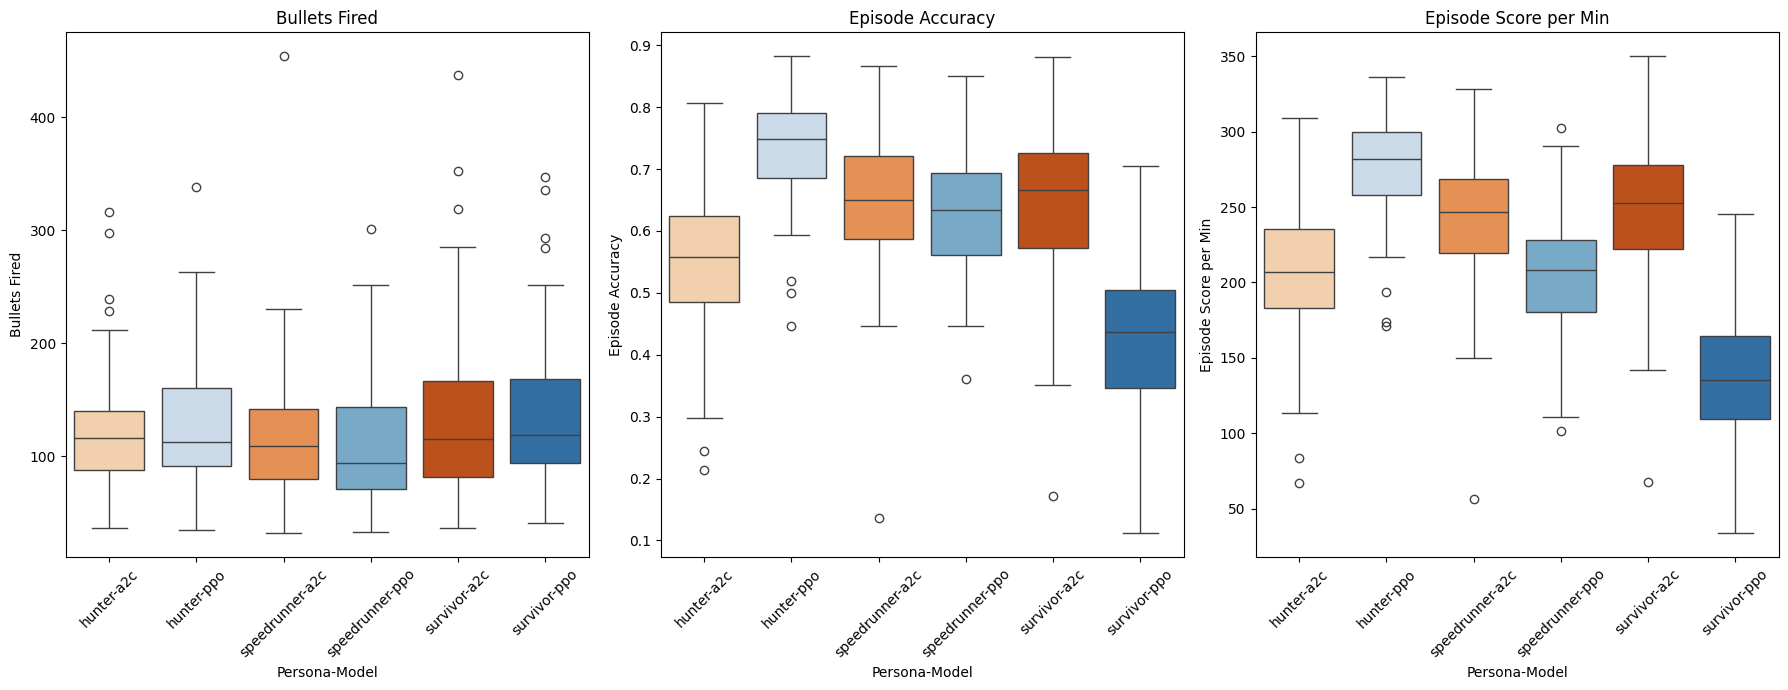

In [69]:
metrics = [
    ('bullets_fired', 'Bullets Fired'),            # Left
    ('episode_accuracy', 'Episode Accuracy'),      # Middle
    ('episode_score_per_min', 'Episode Score per Min')  # Right
]

fig, axes = plt.subplots(1, 3, figsize=(18,7))

for ax, (col, title) in zip(axes, metrics):
    sns.boxplot(
        data=df_plot,
        x='group',
        y=col,
        order=groups,
        hue='group',
        palette=palette,    # palette keyed by 'group'
        legend = False,
        ax=ax,
        showfliers=True
    )
    ax.set_title(title)
    ax.set_xlabel("Persona-Model")
    ax.set_ylabel(title)
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()



### Bullets Fired
Consistency: 
- Most groups have similar medians; however, "survivor-ppo" and "survivor-a2c" display slightly higher medians and longer upper whiskers, indicating these agents tend to fire more bullets on average, possibly as a byproduct of longer episode durations.

Outliers: 
- Both "hunter-ppo" and "speedrunner-ppo" show several high outliers, suggesting that in some episodes, aggressive strategies lead to a large number of shots fired.

### Episode Accuracy
Highest Accuracy: 
- "hunter-ppo" achieves the highest median accuracy, followed closely by "speedrunner-a2c". This demonstrates that hunter-style play under PPO is exceptionally precise, which aligns with their score maximization focus.

Survivor Decline: 
- Both survivor groups have lower median accuracy, especially "survivor-ppo" with the lowest value. This likely reflects their greater focus on staying alive rather than actively targeting and shooting threats.

### Episode Score per Min
Scoring Efficiency: 
- "hunter-ppo" has the highest episode score-per-minute, confirming its efficiency in rapid, effective point accumulation. "survivor-ppo" has the lowest, further illustrating the trade-off between scoring and survival.

Other Groups: 
- The speedrunner and survivor A2C variants remain relatively high, while hunter and speedrunner A2C/ppo all cluster above the survivor-ppo baseline. This supports the idea that aggressive and precise strategies lead to higher point efficiency, especially when coupled with PPO.

### Summary:
PPO and A2C differ most in how they align persona goals with behavioral outcomes. "hunter-ppo" stands out for frequent, accurate, and high-scoring actions. Survivors, in contrast, especially under PPO, favor long games with modest accuracy and scoring rates, reflecting explicit reward trade-offs. The alignment between persona, algorithm, and observed behavior is strongest among aggressive PPO policies and most moderate for survivor strategies.